In [62]:
import pandas as pd
import pickle
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm


In [63]:
# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using: ", device)
torch.cuda.empty_cache()

Using:  cuda


In [64]:
my_seed = 42
random.seed(my_seed)
torch.manual_seed(my_seed)

In [65]:
with open("./rcnn_training_data_transformation_True_step_50_sub_image_size_150.pkl", "rb") as f:
    seal_sub_images = pickle.load(f)

In [66]:
def display_images(image_list, num_images, image_size):
    fig, ax = plt.subplots(ncols=num_images, figsize=(image_size, image_size))
    for idx in range(num_images):
        image = image_list[idx]
        ax[idx].imshow(image)

In [67]:
# Filter out Sub-images below a certain threshold
seal_threshold=.6
filtered_seal_sub_images = []

for image_name in seal_sub_images.keys():
    
    # Extract sub-images anb bounding box information
    sub_image_list, bouding_box_list = seal_sub_images[image_name]
    
    # Filter out sub-images
    for idx in range(len(sub_image_list)):

        # Individual bounding box and sub-image
        bounding_box_data_frame = bouding_box_list[idx]
        sub_image = sub_image_list[idx]

        # Only keep sub-images where atleast one seal is greater than the threshold
        if bounding_box_data_frame.percent.max() >= seal_threshold:
            filtered_seal_sub_images.append(sub_image)


print(f"Sub-images used for training: {len(filtered_seal_sub_images)}")

Sub-images used for training: 54572


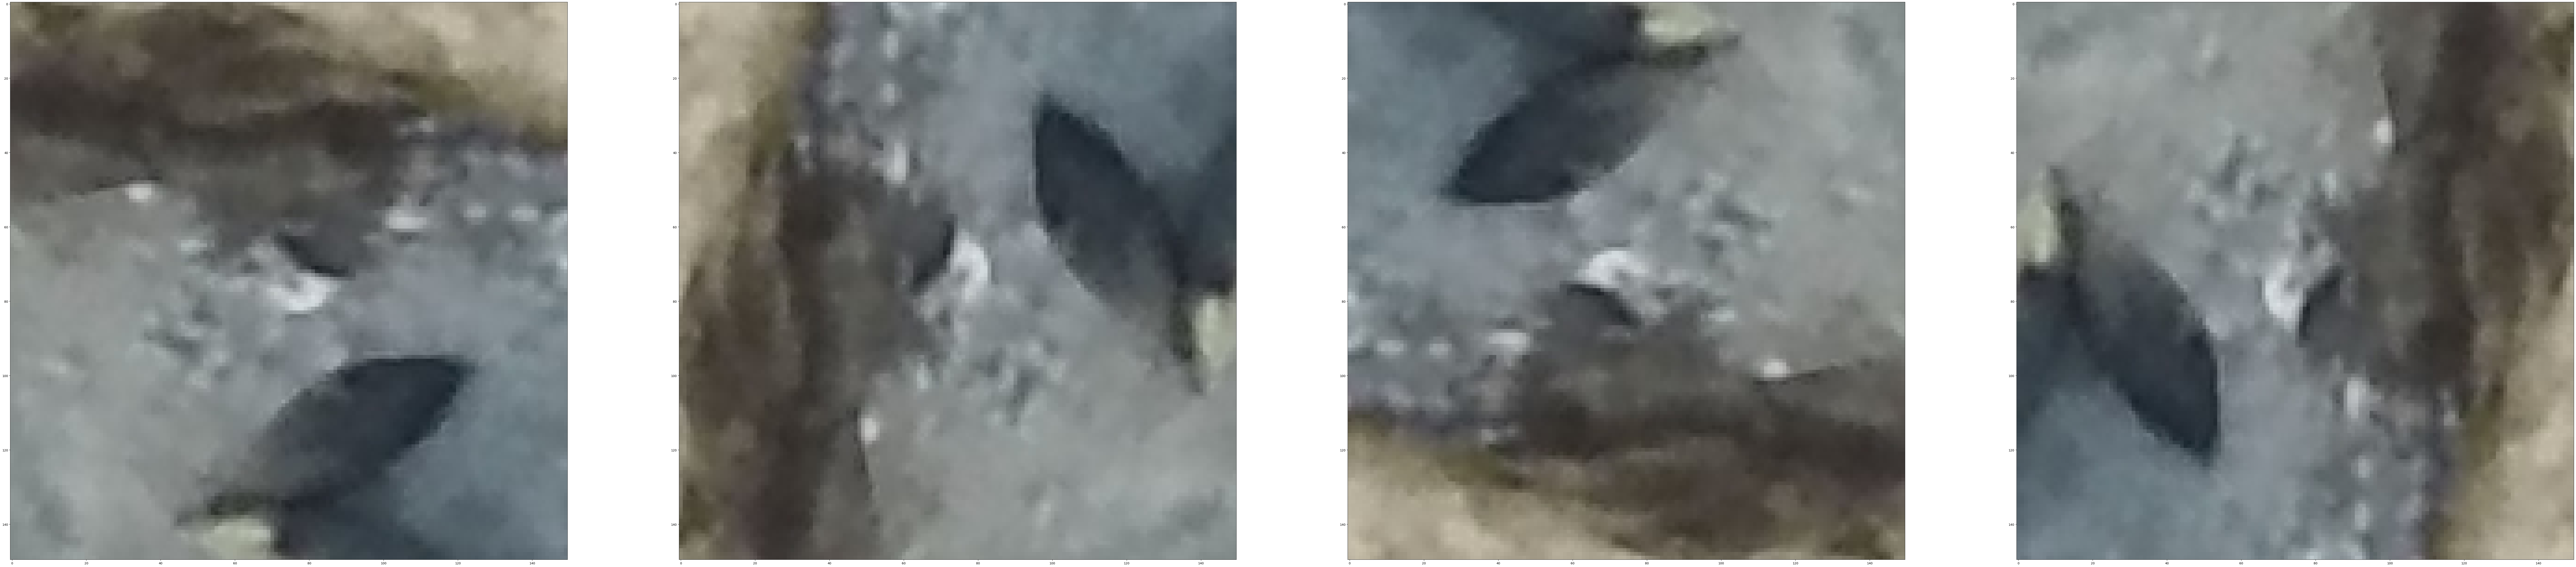

In [68]:
display_images(filtered_seal_sub_images, 4, 150)

In [88]:
# Parameters for DCGAN 
batch_size = 3
image_size = 150
channnels = 3
latent_space = 100
generator_features = 64
discriminator_features = 150
epochs = 50
learning_rate = .0001

In [89]:
def initial_weights_normal_dist(layer):
    layer_type = layer.__class__.__name__
    # Layer is convolutional 
    if layer_type.find("Conv") != -1:
        nn.init.normal_(layer.weight.data, 0, .02)
    elif layer_type.find("BatchNorm") != -1:
        nn.init.normal_(layer.weight.data, 1, .02)
        nn.init.constant(layer.bias.data, 0)

In [90]:
class Generator(nn.Module):
    def __init__(self, channels, features, latent_space, image_size):
        super(Generator, self).__init__()
        self.init_size = (image_size // 4) + 1

        self.initial_layer = nn.Sequential(
            nn.Linear(latent_space, 128 * self.init_size ** 2)
        )

        self.convolutional_blocks = nn.Sequential(
            nn.BatchNorm2d(128),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128, .8),
            nn.LeakyReLU(.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64, .8),
            nn.LeakyReLU(.2, inplace=True),

            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )


    def forward(self, input):
        noise_imgs = self.initial_layer(input)
        noise_imgs = noise_imgs.view(noise_imgs.shape[0], 128, self.init_size, self.init_size)
        generated_imgs = self.convolutional_blocks(noise_imgs)
        return generated_imgs[:, :, :-2, :-2]

In [91]:
# Create generator
generator = Generator(channnels, generator_features, latent_space, image_size=150)

# Initialize with random wieghts following normal distribution
generator.apply(initial_weights_normal_dist)

C:\Users\kaanan\AppData\Local\Temp\ipykernel_6016\299896086.py:8: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(layer.bias.data, 0)


Generator(
  (initial_layer): Sequential(
    (0): Linear(in_features=100, out_features=184832, bias=True)
  )
  (convolutional_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


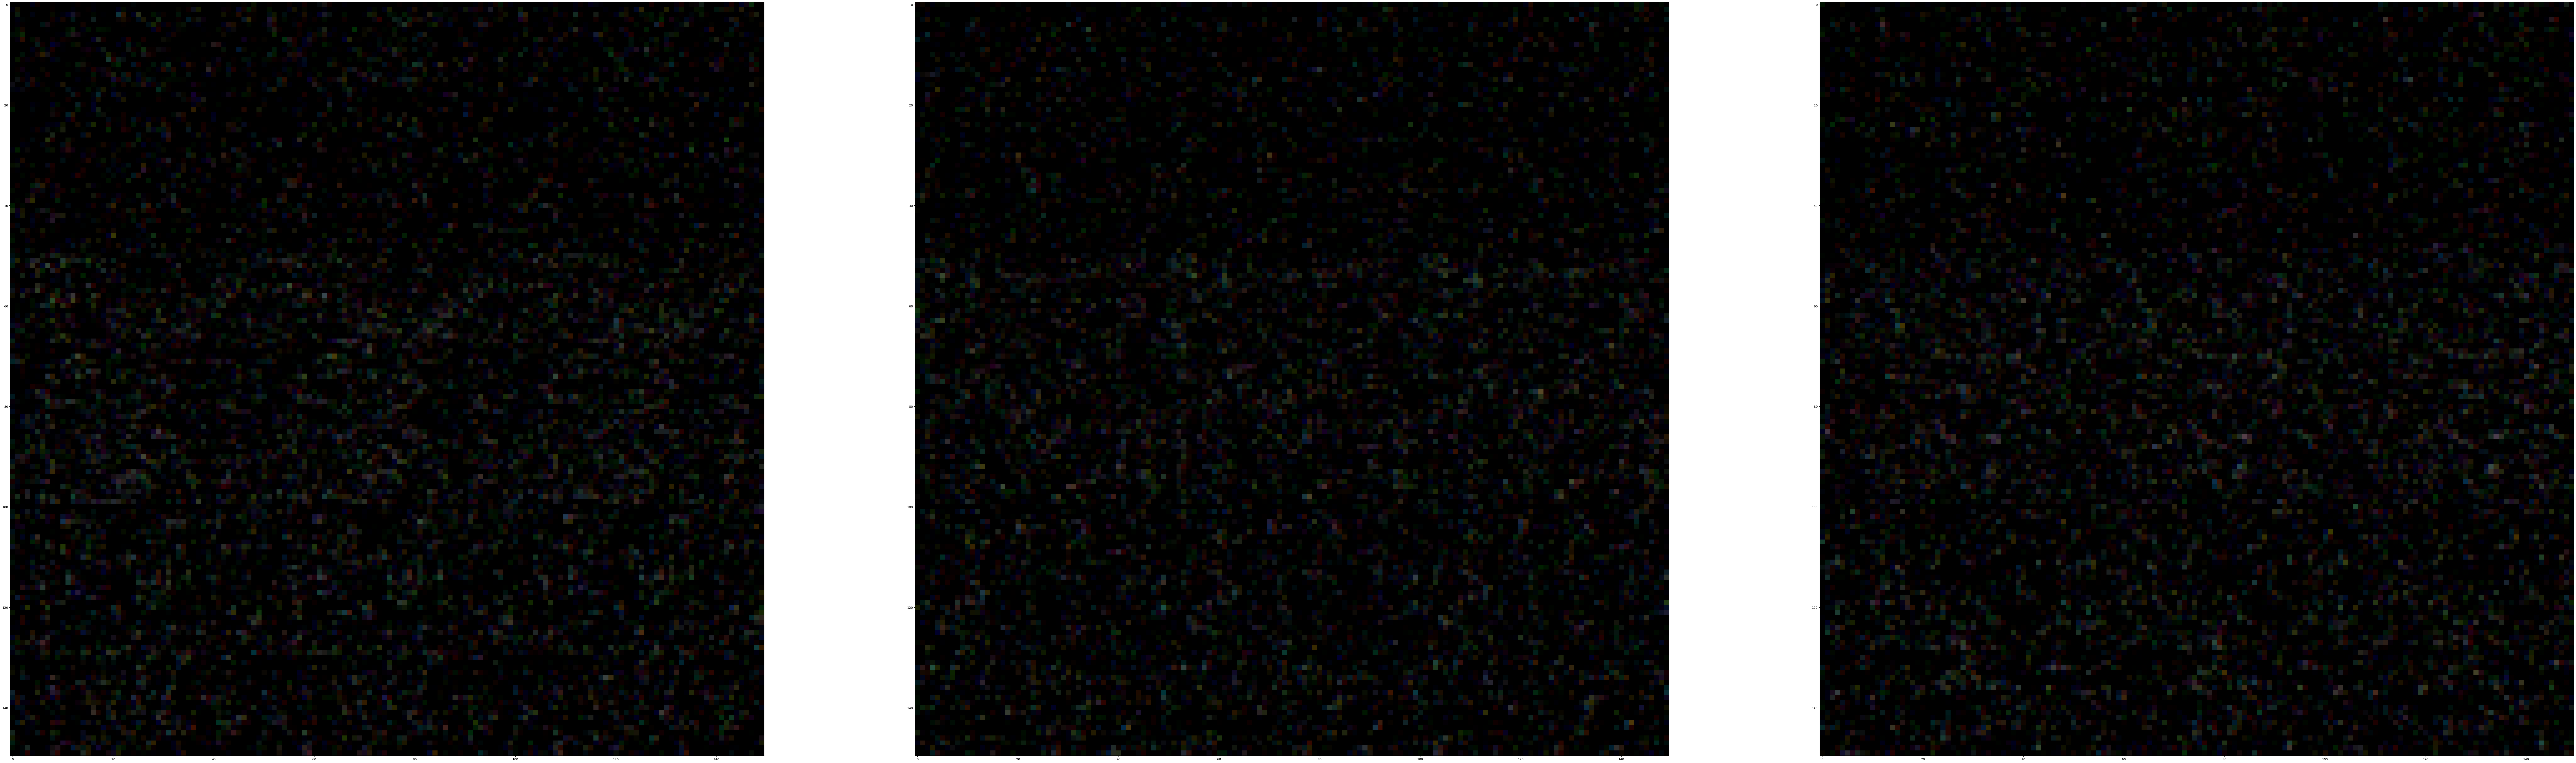

In [95]:
noise = torch.randn((batch_size, latent_space))
generated_images = generator(noise).detach().numpy().reshape(batch_size, 150, 150, 3)
display_images(generated_images, batch_size, 150)